In [586]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [587]:
pathTest = "./test3.csv"
pathTrain = "./train3.csv"

# Importe les jeux de donnees
df_test = pd.read_csv(pathTest, sep=',', index_col=0)
df_train = pd.read_csv(pathTrain, sep=',', index_col=0)

In [588]:
X_train = df_train

# On enlève le nom qui sert à rien 

X_train = X_train.drop(['Name'], axis =1)

In [589]:
# On encode par des entiers les colonnes Platform, Genre, Publisher et Developer.

from sklearn.preprocessing import LabelEncoder
platform = LabelEncoder()
genre = LabelEncoder()
publisher = LabelEncoder()
developer = LabelEncoder()


X_train["Platform"] = platform.fit_transform(X_train["Platform"].astype(str))
X_train["Genre"] = genre.fit_transform(X_train["Genre"].values.astype(str))
X_train["Publisher"] = publisher.fit_transform(X_train["Publisher"].values.astype(str))
X_train["Developer"] = developer.fit_transform(X_train["Developer"].astype(str))

In [590]:
X_train['NA_Sales'].unique().shape

(14094,)

In [591]:
# On remplit les nan par des medianes dans les colonnes suivantes : 
# A remplacer par une moyenne d'intervalles. 

X_train["Year_of_Release"]=X_train["Year_of_Release"].fillna(X_train["Year_of_Release"].median())
X_train["Critic_Score"]=X_train["Critic_Score"].fillna(X_train["Critic_Score"].median())
X_train["Critic_Count"]=X_train["Critic_Count"].fillna(X_train["Critic_Count"].median())
X_train["User_Score"]=X_train["User_Score"].fillna(X_train["User_Score"].median())
X_train["User_Count"]=X_train["User_Count"].fillna(X_train["User_Count"].median())
X_train["NA_Sales"]=X_train["NA_Sales"].fillna(X_train["NA_Sales"].median())
X_train["Global_Sales"]=X_train["Global_Sales"].fillna(X_train["Global_Sales"].median())
X_train.Publisher = X_train.Publisher.replace(np.nan, "Unknown")


#X_train["Rating"]=X_train["Rating"].fillna(X_train["Rating"].median()) A traiter

In [592]:
X_train.head()

,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,NA_Sales,Global_Sales
ID,,,,,,,,,,,,,,
1,4,2004.0,5,226,0.050524,0.010024,74.0,40.0,7.5,13.0,235,E,0.101432,0.172605
2,4,2010.0,0,331,0.039211,0.001791,71.0,21.0,7.5,25.0,1588,NaN,0.000440,0.043251
3,4,2006.0,10,461,0.000374,0.001797,71.0,21.0,7.5,25.0,1330,E,0.030829,0.041271
4,15,2002.0,4,467,0.001382,0.140010,71.0,21.0,6.6,41.0,180,E,0.528330,1.080821
5,19,2014.0,0,477,0.069422,0.009535,67.0,19.0,7.5,61.0,762,M,0.020629,0.131074


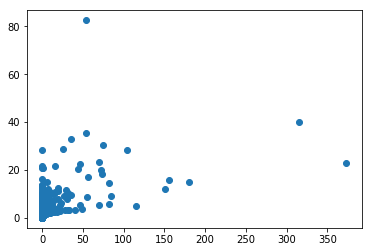

In [593]:
# Plot poour voir liens entre les X.i et les y.i



plt.scatter(X_train['JP_Sales']**3, X_train['Global_Sales'])
plt.show()

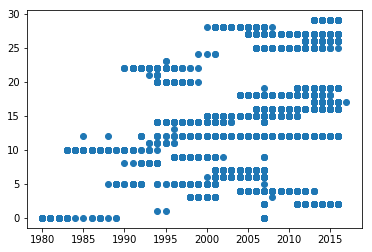

In [594]:
plt.scatter(X_train['Year_of_Release'], X_train['Platform'])
plt.show()

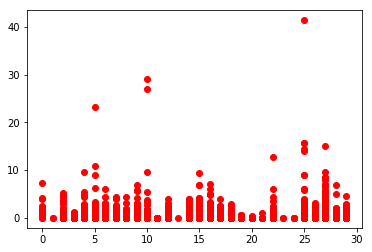

In [595]:
plt.plot(X_train['Platform'], X_train['NA_Sales'],'ro')
plt.show()

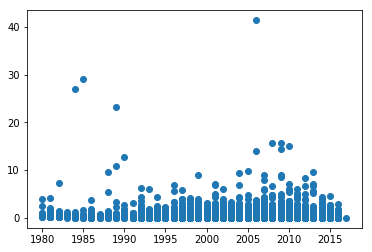

In [596]:
plt.scatter(X_train['Year_of_Release'], X_train['NA_Sales'])
plt.show()

In [597]:
# Clustering entre les NA/Global et le publisher, on obtient 100 clusters différents qui remplacent nos 500 publishers différents

NA_means = np.zeros(X_train['Publisher'].unique().shape)
Global_means = np.zeros(X_train['Publisher'].unique().shape)
P = np.zeros(X_train['Publisher'].unique().shape)
compteur = np.zeros(X_train['Publisher'].unique().shape)

# On calcule pour chaque publisher, une moyenne des NA_sales et Global_sales qui leurs sont attribués. 
for i in range(X_train.shape[0]):
    indice = X_train.iloc[i,3]
    NA_means[indice]=NA_means[indice]+X_train.iloc[i,12]
    Global_means[indice]=Global_means[indice]+X_train.iloc[i,13]
    compteur[indice]=compteur[indice]+1

for i in range(len(NA_means)):
    NA_means[i]=NA_means[i]/compteur[i]
    Global_means[i]=Global_means[i]/compteur[i]

    
    
# On effectue les Kmeans pour associer à chaque publisher le centroid le plus proche.     
    
data = np.c_[NA_means,Global_means]
X_cluster=pd.DataFrame(data = data, columns = ['NA','Global'])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=0).fit(X_cluster)

In [598]:
# Regression linéaire avec User_Score + Critic. On split les données de X_train, on entraine le modèle et on prédit X_test1.


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


data2 = np.c_[X_train['JP_Sales'],X_train['Other_Sales'], X_train['User_Score']*X_train['User_Count'],X_train['Critic_Score']*X_train['Critic_Count']]
target = X_train['NA_Sales']
target2 = X_train['Global_Sales']
X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, target, test_size=0.33, random_state=10)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.33, random_state=10)


reg_NA = LinearRegression().fit(X_train1, y_train1)
reg_Global = LinearRegression().fit(X_train2, y_train2)

pred_NA = reg_NA.predict(X_test1)
pred_Global = reg_Global.predict(X_test2)

In [599]:
pred_NA.mean()

0.26558647062490587

In [600]:
# On analyse les résultats

from sklearn.metrics import mean_squared_error, r2_score


print('Coefficients: \n', reg_NA.coef_)
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test1, pred_NA))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %.2f' % r2_score(y_test1, pred_NA))


print('Coefficients: \n', reg_Global.coef_)
# The mean squared error


print("Mean squared error: %.2f"% mean_squared_error(y_test2, pred_Global))
# Explained variance score: 1 is perfect prediction
print('Variance score (R2): %.2f' % r2_score(y_test2, pred_Global))

Coefficients: 
 [9.50861361e-01 2.18984954e+00 9.26408299e-06 5.27263541e-05]
Mean squared error: 0.23
Variance score (R2): 0.50
Coefficients: 
 [2.37084653e+00 4.69044508e+00 2.28834260e-05 8.19663703e-05]
Mean squared error: 0.41
Variance score (R2): 0.77


In [601]:
df_test = pd.read_csv(pathTest, sep=',', index_col=0)

In [602]:
# On applique le modèle sur les données d'entrainement entières. 




df_test = df_test.drop(['Platform'],axis = 1)
df_test = df_test.drop(['Year_of_Release'],axis = 1)
df_test = df_test.drop(['Genre'],axis = 1)
df_test = df_test.drop(['Publisher'],axis = 1)
#df_test = df_test.drop(['Critic_Score'],axis = 1)
#df_test = df_test.drop(['User_Count'],axis = 1)
#df_test = df_test.drop(['User_Score'],axis = 1)
#df_test = df_test.drop(['Critic_Count'],axis = 1)
df_test = df_test.drop(['Developer'],axis = 1)
df_test = df_test.drop(['Rating'],axis = 1)

In [603]:
df_test.head()

,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count
ID,,,,,,
14095,0.000521,0.000257,24.0,11.0,3.7,10.0
14096,0.000966,0.020463,72.0,35.0,7.7,27.0
14097,0.259834,0.048938,NaN,NaN,NaN,NaN
14098,0.000888,0.008269,81.0,20.0,8.7,43.0
14099,0.000439,0.038802,63.0,68.0,7.2,201.0


In [604]:
df_test["Critic_Score"]=df_test["Critic_Score"].fillna(df_test["Critic_Score"].median())
df_test["Critic_Count"]=df_test["Critic_Count"].fillna(df_test["Critic_Count"].median())
df_test["User_Score"]=df_test["User_Score"].fillna(df_test["User_Score"].median())
df_test["User_Count"]=df_test["User_Count"].fillna(df_test["User_Count"].median())

In [605]:
df_test.head()

,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count
ID,,,,,,
14095,0.000521,0.000257,24.0,11.0,3.7,10.0
14096,0.000966,0.020463,72.0,35.0,7.7,27.0
14097,0.259834,0.048938,71.0,22.0,7.5,24.0
14098,0.000888,0.008269,81.0,20.0,8.7,43.0
14099,0.000439,0.038802,63.0,68.0,7.2,201.0


In [606]:
reg_NA = LinearRegression().fit(data2, target)
data_test_Reg = np.c_[df_test['JP_Sales'],df_test['Other_Sales'], df_test['User_Score']*df_test['User_Count'],df_test['Critic_Score']*df_test['Critic_Count'] ]
pred_NA = pd.DataFrame(data = reg_NA.predict(data_test_Reg), columns =['NA_Sales'])

In [607]:
reg_Global = LinearRegression().fit(data2, target2)
pred_Global = pd.DataFrame(data = reg_Global.predict(data_test_Reg), columns =['Global_Sales'])

In [608]:
ID = np.zeros(2490)
for i in range(2490):
    ID[i]=int(i+14095)

In [609]:
Y_final['ID']=ID
Y_final['ID'] = Y_final['ID'].astype(int)
Y_final['NA_Sales'] = pred_NA
Y_final['Global_Sales'] = pred_Global

In [616]:
print(Y_final['NA_Sales'].mean())
print(Y_final['Global_Sales'].mean())

0.27663188512065834
0.5642201949377034


In [611]:
Y_final = Y_final[['ID', 'NA_Sales', 'Global_Sales']]

In [612]:
Y_final.to_csv('pred_3301.csv', encoding='utf-8', index=False)